# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

In [1]:
!pwd

/home/docker/packages/TVB-NEST-usecase2/cosim_example_demos/TVB-NEST-demo


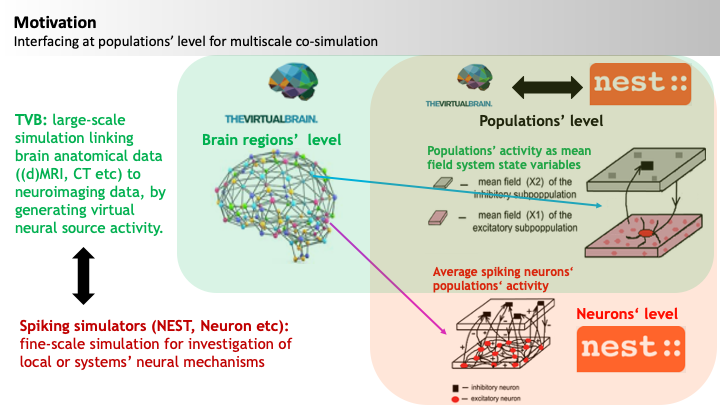

In [2]:
from IPython.display import Image, display
display(Image(filename='/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/pics/ConceptGraph1.png',  width=1000, unconfined=False))

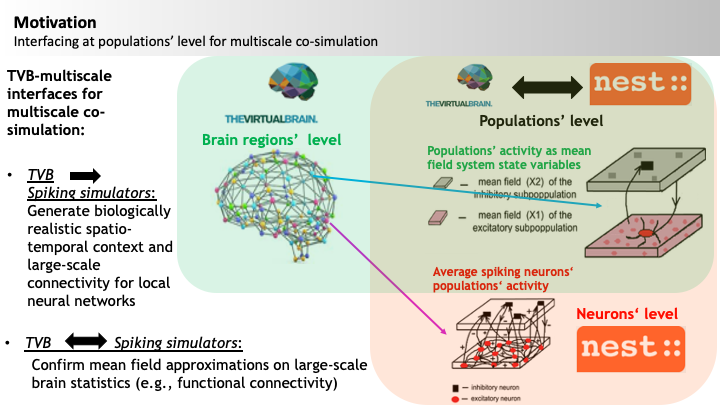

In [3]:
display(Image(filename='/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Wilson - Cowan TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

Population activity dynamics (1 excitatory and 1 inhibitory population):

 $\dot{E}_k = \dfrac{1}{\tau_e} (-E_k  + (k_e - r_e E_k) \mathcal{S}_e (\alpha_e \left( c_{ee} E_k - c_{ei} I_k  + P_k - \theta_e + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) )) $
 
$
            \dot{I}_k = \dfrac{1}{\tau_i} (-I_k  + (k_i - r_i I_k) \mathcal{S}_i (\alpha_i \left( c_{ie} E_k - c_{ee} I_k  + Q_k - \theta_i + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) ))$


## Spiking network model in NEST

using "iaf_cond_alpha" spiking neuronal model.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * E(t) $, 

Inhomogeneous spike generator NEST devices are used as TVB "proxy" nodes and generate independent Poisson-random spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Alternatively, the spike trains are generated outside NEST using the Elephant software and inserted to NEST via spike generator devices.



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {E_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E * dt} $ 

$ {I_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I * dt} $

in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., minimally 2) NEST time steps for every 1 TVB time step for stable integration

### Synchronizaion every minimum delay time between the two simulators.

# WORKFLOW:

In [4]:
from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import Config
from examples.parallel.wilson_cowan.config import configure

config = configure(config_class=Config)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2023-06-29 15:01:40,927 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2023-06-29 15:01:40,927 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2023-06-29 15:01:40,935 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2023-06-29 15:01:40,935 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2023-06-29 15:01:40,942 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2023-06-29 15:01:40,942 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2023-06-29 15:01:40,949 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2023-06-29 15:01:40,949 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2023-06-29 15:01:40,955 - INFO - tvb_multiscale.tv

Config (
  title .............................. 'Config gid: a878a071-037c-49e1-8ef4-deb172997054'
  Type ............................... 'Config'
  gid ................................ UUID('a878a071-037c-49e1-8ef4-deb172997054')
  config.gid ......................... UUID('a878a071-037c-49e1-8ef4-deb172997054')
  config.title ....................... 'Config gid: a878a071-037c-49e1-8ef4-deb172997054'
  config.log ......................... <Logger tvb_multiscale.tvb_nest.config (DEBUG)>
  config.VERBOSITY ................... 1
  config.out ......................... OutputConfig gid: 8c37eb1d-2068-4c71-98a1-c9047b37ce78
  config.figures ..................... FiguresConfig
  config.DEFAULT_SUBJECT[connectivity]  Connectivity gid: 2d8b0c00-9eb1-48be-a119-3cf2734e5c2c
  config.DEFAULT_SUBJECT[cortex] ..... Cortex gid: e9c23156-7c4d-4f41-bb25-f54623871758
  config.DEFAULT_SUBJECT_PATH ........ '/home/docker/packages/tvb-multiscale/examples/data/tvb_data/berlinSubjects/QL_20120814'
  config.

## BACKEND: 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [5]:
# This would run on TVB only before creating any multiscale cosimulation interface connections.
from examples.parallel.tvb_nest.wilson_cowan.tvb_config import build_tvb_simulator

simulator = build_tvb_simulator(config=config, config_class=Config)


2023-06-29 15:01:43,578 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_parallel - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
CoSimulatorParallel (
  title ........................... 'CoSimulatorParallel gid: 60567e45-3c91-480f-8736-b806c2020538'
  Type ............................ 'CoSimulatorParallel'
  model ........................... WilsonCowan gid: b2123a53-1b52-4c8a-b6ea-c546004ea032
  output_interfaces ............... None
  input_interfaces ................ None
  out_proxy_inds .................. --------------------
  shape ........................... (0,)
  dtype ........................... int64
  is empty ........................ True
  exclusive ....................... False
  voi ............................. --------------------
  proxy_inds ...................... --------------------
  synchronization_time ............ 0.0
  connectivity .................... Connectivity gid: 5b9e213a-7a25-49ab-a578-7ddb23b2def0
  conduction_speed ...............

## BACKEND: 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [6]:
# This would run on NEST only before creating any multiscale cosimulation interface connections.
# Here it is assumed that the TVB simulator is already created and we can get some of its attributes, 
# either by directly accessing it, or via serialization.

from examples.parallel.tvb_nest.wilson_cowan.nest_config import build_nest_network


# nest_network = build_nest_network(config=config, config_class=Config)



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: HEAD@c545255f7
 Built: Nov 15 2022 13:46:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## FRONTEND: 3. Build the TVB-NEST interface

In [7]:

# options for a nonopinionated builder:
from tvb_multiscale.core.interfaces.base.transformers.models.models import Transformers
from tvb_multiscale.core.interfaces.base.transformers.builders import \
        DefaultTVBtoSpikeNetTransformers, DefaultSpikeNetToTVBTransformers, \
        DefaultTVBtoSpikeNetModels, DefaultSpikeNetToTVBModels
from tvb_multiscale.tvb_nest.interfaces.builders import \
        TVBtoNESTModels, NESTInputProxyModels, DefaultTVBtoNESTModels, \
        NESTtoTVBModels, NESTOutputProxyModels, DefaultNESTtoTVBModels

    
    
def print_enum(enum):
    print("\n", enum)
    for name, member in enum.__members__.items():
        print(name,"= ", member.value)
    
    
print("Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:")
print_enum(TVBtoNESTModels)
print_enum(NESTtoTVBModels)
    
    
print("\n\nAvailable input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:")

print_enum(DefaultTVBtoSpikeNetModels)
print_enum(DefaultTVBtoSpikeNetTransformers)
    
print_enum(DefaultSpikeNetToTVBModels)
print_enum(DefaultSpikeNetToTVBTransformers)    
    
    
print("\n\nAvailable input (NEST->TVB update) / output (TVB->NEST coupling) proxy models:")

print_enum(DefaultTVBtoNESTModels)
print_enum(NESTInputProxyModels)
    
print_enum(NESTOutputProxyModels)
print_enum(DefaultNESTtoTVBModels)
    
print("\n\nAll basic transformer models:")
print_enum(Transformers)
    


Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:

 <enum 'TVBtoSpikeNetModels'>
RATE =  0
SPIKES =  1
CURRENT =  2

 <enum 'SpikeNetToTVBModels'>
SPIKES =  0
VOLTAGE =  1


Available input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:

 <enum 'DefaultTVBtoSpikeNetModels'>
RATE =  RATE
SPIKES =  SPIKES_SINGLE_INTERACTION
CURRENT =  CURRENT

 <enum 'DefaultTVBtoSpikeNetTransformers'>
RATE =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate'>
SPIKES =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoisson'>
SPIKES_SINGLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonSingleInteraction'>
SPIKES_MULTIPLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonMultipleInteraction'>
CURRENT =  <class 'tvb_multiscale.core.int

In [8]:
from examples.parallel.tvb_nest.wilson_cowan.tvb_interface_config import configure_TVB_interfaces
from examples.parallel.tvb_nest.wilson_cowan.nest_interface_config import configure_NEST_interfaces
from examples.parallel.tvb_nest.wilson_cowan.transformers_config import \
    configure_TVBtoNEST_transformer_interfaces, configure_NESTtoTVB_transformer_interfaces

tvb_interface_builder = configure_TVB_interfaces(simulator=simulator, config=config, config_class=Config)

nest_interface_builder = configure_NEST_interfaces(config=config, config_class=Config)

tvb_to_nest_interface_builder = configure_TVBtoNEST_transformer_interfaces(config=config, config_class=Config)

nest_to_tvb_interface_builder = configure_NESTtoTVB_transformer_interfaces(config=config, config_class=Config)



output (TVB-> coupling) interfaces' configurations:

[{'voi': array(['E'], dtype='<U1'), 'coupling_mode': 'TVB', 'proxy_inds': array([0, 1])}]

input (TVB<- update) interfaces' configurations:

[{'voi': array(['E'], dtype='<U1'), 'proxy_inds': array([0, 1])}, {'voi': array(['I'], dtype='<U1'), 'proxy_inds': array([0, 1])}]

input (spikeNet <- coupling) interfaces' configurations:

[{'populations': array(['E'], dtype='<U1'), 'coupling_mode': 'TVB', 'proxy_inds': array([0, 1]), 'proxy_model': 'RATE', 'spiking_proxy_inds': array([0, 1])}]

output (spikeNet -> update) interfaces' configurations:

[{'populations': array(['E'], dtype='<U1'), 'proxy_inds': array([0, 1]), 'proxy_model': 'SPIKES_MEAN'}, {'populations': array(['I'], dtype='<U1'), 'proxy_inds': array([0, 1]), 'proxy_model': 'SPIKES_MEAN'}]

output (->Transformer-> coupling) interfaces' configurations:

[{'transformer_model': 'RATE', 'transformer_params': {'scale_factor': array([500000.])}}]

input (TVB<-...-Transformer<-...-spik

## BACKEND:
### - Build TVB and Spiking Network models and simulators
### - Build interfaces
### - Configure co-simulation

In [9]:
from nest_elephant_tvb.tvb.backend import init as tvb_init
from nest_elephant_tvb.nest.backend import init as nest_init
from nest_elephant_tvb.Interscale_hub.backend import tvb_to_nest_init, nest_to_tvb_init


In [10]:
tvb_app = tvb_init(config, tvb_cosimulator_builder=build_tvb_simulator)




Starting App TVBParallelApp...

Setting TVB LIBRARY_PROFILE...

Building with App TVBParallelApp...

Building interfaces' with builder TVBInterfaceBuilder of App TVBParallelApp...

Building TVB CoSimulator with builder script build_tvb_simulator of App TVBParallelApp...
2023-06-29 15:01:45,148 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_parallel - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
CoSimulatorParallel (
  title ........................... 'CoSimulatorParallel gid: bef3f4af-e06d-4dc5-aadc-bd095537bddf'
  Type ............................ 'CoSimulatorParallel'
  model ........................... WilsonCowan gid: 91e1c5e2-be1d-4151-94d7-70972ab32a9c
  output_interfaces ............... None
  input_interfaces ................ None
  out_proxy_inds .................. --------------------
  shape ........................... (0,)
  dtype ........................... int64
  is empty ........................ True
  exclusive ....................... False
  voi .

Failed to summarize: 
monitors
tuple
'NoneType' object has no attribute 'tolist'

CoSimulatorParallel (
  title ........................... 'CoSimulatorParallel gid: bef3f4af-e06d-4dc5-aadc-bd095537bddf'
  Type ............................ 'CoSimulatorParallel'
  model ........................... WilsonCowan gid: 91e1c5e2-be1d-4151-94d7-70972ab32a9c
  output_interfaces ............... TVBOutputInterfaces gid: b0d5e2c6-cc47-4b80-9d58-925cebccf193
  input_interfaces ................ TVBInputInterfaces gid: 9af96bc8-bdc1-48e2-828b-8ec7186a196b
  out_proxy_inds .................. --------------------
  out_proxy_inds: shape ........... (2,)
  out_proxy_inds: dtype ........... int64
  out_proxy_inds: values .......... [[0, 1]]
  exclusive ....................... True
  voi ............................. --------------------
  voi: shape ...................... (2,)
  voi: dtype ...................... int64
  voi: values ..................... [[0, 1]]
  proxy_inds ...................... ------

In [11]:

nest_app = nest_init(config, build_nest_network)




Starting App NESTParallelApp...

Building with App NESTParallelApp...

Building Spiking Network with builder script build_nest_network of App NESTParallelApp...
Building NESTNetwork...
2023-06-29 15:01:45,624 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!
2023-06-29 15:01:45,624 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!

...created: OrderedDict([('title', "'NESTPopulation gid: 48f39916-9916-4f08-9c0f-4ad5d1a38705'"), ('Type', "'NESTPopulation'"), ('_nodes', 'NodeCollection(metadata=None, model=iaf_cond_alpha, size=100, first=1, last=100)'), ('label', "'E'"), ('model', "'NESTPopulation'"), ('brain_region', "'bankssts_L'"), ('gid', "UUID('48f39916-9916-4f08-9c0f-4ad5d1a38705')"), ('number_of_nodes', '100'), ('nodes', 'NodeCollection(metadata=None, model=iaf_cond_alpha, size=100, first=1, last=100)')])...

...created: Ord

2023-06-29 15:01:58,103 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['E']-> created!
2023-06-29 15:01:58,130 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['I']-> created!
2023-06-29 15:01:58,130 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['I']-> created!
2023-06-29 15:01:58,156 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for ->['E'] created!
2023-06-29 15:01:58,156 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for ->['E'] created!

NESTInputInterfaces (
  title .....

In [12]:
tvb_to_nest_app = tvb_to_nest_init(config)

nest_to_tvb_app = nest_to_tvb_init(config)


Starting App TVBtoSpikeNetTransformerApp...

Building with App TVBtoSpikeNetTransformerApp...

Building interfaces' with builder TVBtoSpikeNetTransformerInterfaceBuilder of App TVBtoSpikeNetTransformerApp...

Instantiating interfaces' builder TVBtoSpikeNetTransformerInterfaceBuilder of App TVBtoSpikeNetTransformerApp...

Configuring interfaces' builder TVBtoSpikeNetTransformerInterfaceBuilder of App TVBtoSpikeNetTransformerApp...

Reading interfaces' configurations from files...

TVBtoSpikeNetTransformerInterfaces (
  title ................... 'TVBtoSpikeNetTransformerInterfaces gid: d9b19cfd-3924-4d09-936f-c708e86637d2'
  Type .................... 'TVBtoSpikeNetTransformerInterfaces'
  interfaces[0] ........... '--------------------'
  interfaces[0].title ..... 'TVBtoSpikeNetTransformerInterface gid: 31276eac-bafa-42dd-b831-c23838bf3bd2'
  interfaces[0].Type ...... 'TVBtoSpikeNetTransformerInterface'
  interfaces[0].transformer  LinearRate gid: 975d2bcd-5020-47a0-a840-58e03c49d551
  

## 4. Simulate, gather results

In [13]:

def run_for_synchronization_time(tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, 
                                trans_to_tvb_cosim_updates):
    tvb_to_trans_cosim_updates = tvb_app.run_for_synchronization_time(trans_to_tvb_cosim_updates)
    trans_to_nest_cosim_updates = tvb_to_nest_app.run_for_synchronization_time(tvb_to_trans_cosim_updates)
    nest_to_trans_cosim_updates = nest_app.run_for_synchronization_time(trans_to_nest_cosim_updates)
    trans_to_tvb_cosim_updates = nest_to_tvb_app.run_for_synchronization_time(nest_to_trans_cosim_updates)
    return tvb_app.cosimulator.n_tvb_steps_ran_since_last_synch, trans_to_tvb_cosim_updates

    
def run_cosimulation(tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, 
                     advance_simulation_for_delayed_monitors_output=True):
    
    import time
    import numpy as np

    simulation_length = tvb_app.cosimulator.simulation_length
    synchronization_time = tvb_app.cosimulator.synchronization_time
    synchronization_n_step = tvb_app.cosimulator.synchronization_n_step  # store the configured value
    dt = tvb_app.cosimulator.integrator.dt
    
    steps_to_simulate = int(np.round(simulation_length / dt))
    simulated_steps = 0
    trans_to_tvb_cosim_updates = None
    
    tvb_app.cosimulator._tic = time.time()
    while steps_to_simulate-simulated_steps > 0:
        current_simulated_steps, trans_to_tvb_cosim_updates = \
            run_for_synchronization_time(tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, 
                                         trans_to_tvb_cosim_updates)
        simulated_steps += current_simulated_steps
        tvb_app.cosimulator._log_print_progress_message(simulated_steps, simulation_length)
        
    if advance_simulation_for_delayed_monitors_output:
        # Run once more for synchronization steps in order to get the full delayed monitors' outputs:
        remaining_steps = \
            int(np.round((simulation_length + synchronization_time - simulated_steps*dt) / dt))
        if remaining_steps:
            remaining_time = remaining_steps * dt
            if tvb_app.verbosity:
                tvb_app._logprint("Simulating for excess time %0.3f..." % remaining_time)
            tvb_app.cosimulator.synchronization_time = remaining_time
            tvb_app.cosimulator.synchronization_n_step = remaining_steps
            nest_app.synchronization_time = remaining_time
            current_simulated_steps, trans_to_tvb_cosim_updates = \
                run_for_synchronization_time(tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, 
                                             trans_to_tvb_cosim_updates)
            simulated_steps += current_simulated_steps
            tvb_app.cosimulator.synchronization_time = synchronization_time
            tvb_app.cosimulator.synchronization_n_step = synchronization_n_step
            nest_app.synchronization_time = synchronization_time
            
    tvb_app.cosimulator.simulation_length = simulated_steps * dt  # update the configured value

    return tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, trans_to_tvb_cosim_updates



In [14]:
tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, trans_to_tvb_cosim_updates = \
    run_cosimulation(tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app, 
                     advance_simulation_for_delayed_monitors_output=True)

results = tvb_app.return_tvb_results()


...8.993% completed in 2.28323 sec!!!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain


...23.022% completed in 5.55066 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 7 last spike(s) of the input spiketrain


...25.899% completed in 6.31456 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 5 last spike(s) of the input spiketrain


...29.856% completed in 8.06008 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 26 last spike(s) of the input spiketrain


...33.813% completed in 9.18499 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain


...50.719% completed in 13.5503 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 23 last spike(s) of the input spiketrain


...54.676% completed in 14.6028 sec!

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 6 last spike(s) of the input spiketrain


...100.000% completed in 27.4088 sec!
Simulating for excess time 3.600...


## 5. Plot results and write them to HDF5 files

In [15]:

from tvb_multiscale.core.plot.plotter import Plotter


# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9

# Set the transient time to be optionally removed from results:
simulation_length = tvb_app.cosimulator.simulation_length
transient = 0.1 * simulation_length 

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

plotter = Plotter(config.figures)

try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    from examples.plot_write_results import write_RegionTimeSeriesXarray_to_h5
    writer = H5Writer()
    
except:
    writer = False
    

2023-06-29 15:02:27,628 - INFO - tvb.storage.h5.encryption.data_encryption_handler - Cannot import syncrypto library.


<Figure size 640x480 with 0 Axes>

### TVB plots and Spiking Network plots upon finalizing


Cleaning up App SpikeNetToTVBTransformerApp...

Stopping App SpikeNetToTVBTransformerApp...

Cleaning up App TVBtoSpikeNetTransformerApp...

Stopping App TVBtoSpikeNetTransformerApp...

Plotting results with App NESTParallelApp...
2023-06-29 15:02:28,564 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2023-06-29 15:02:28,564 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!


/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 27 last spike(s) of the input spiketrain


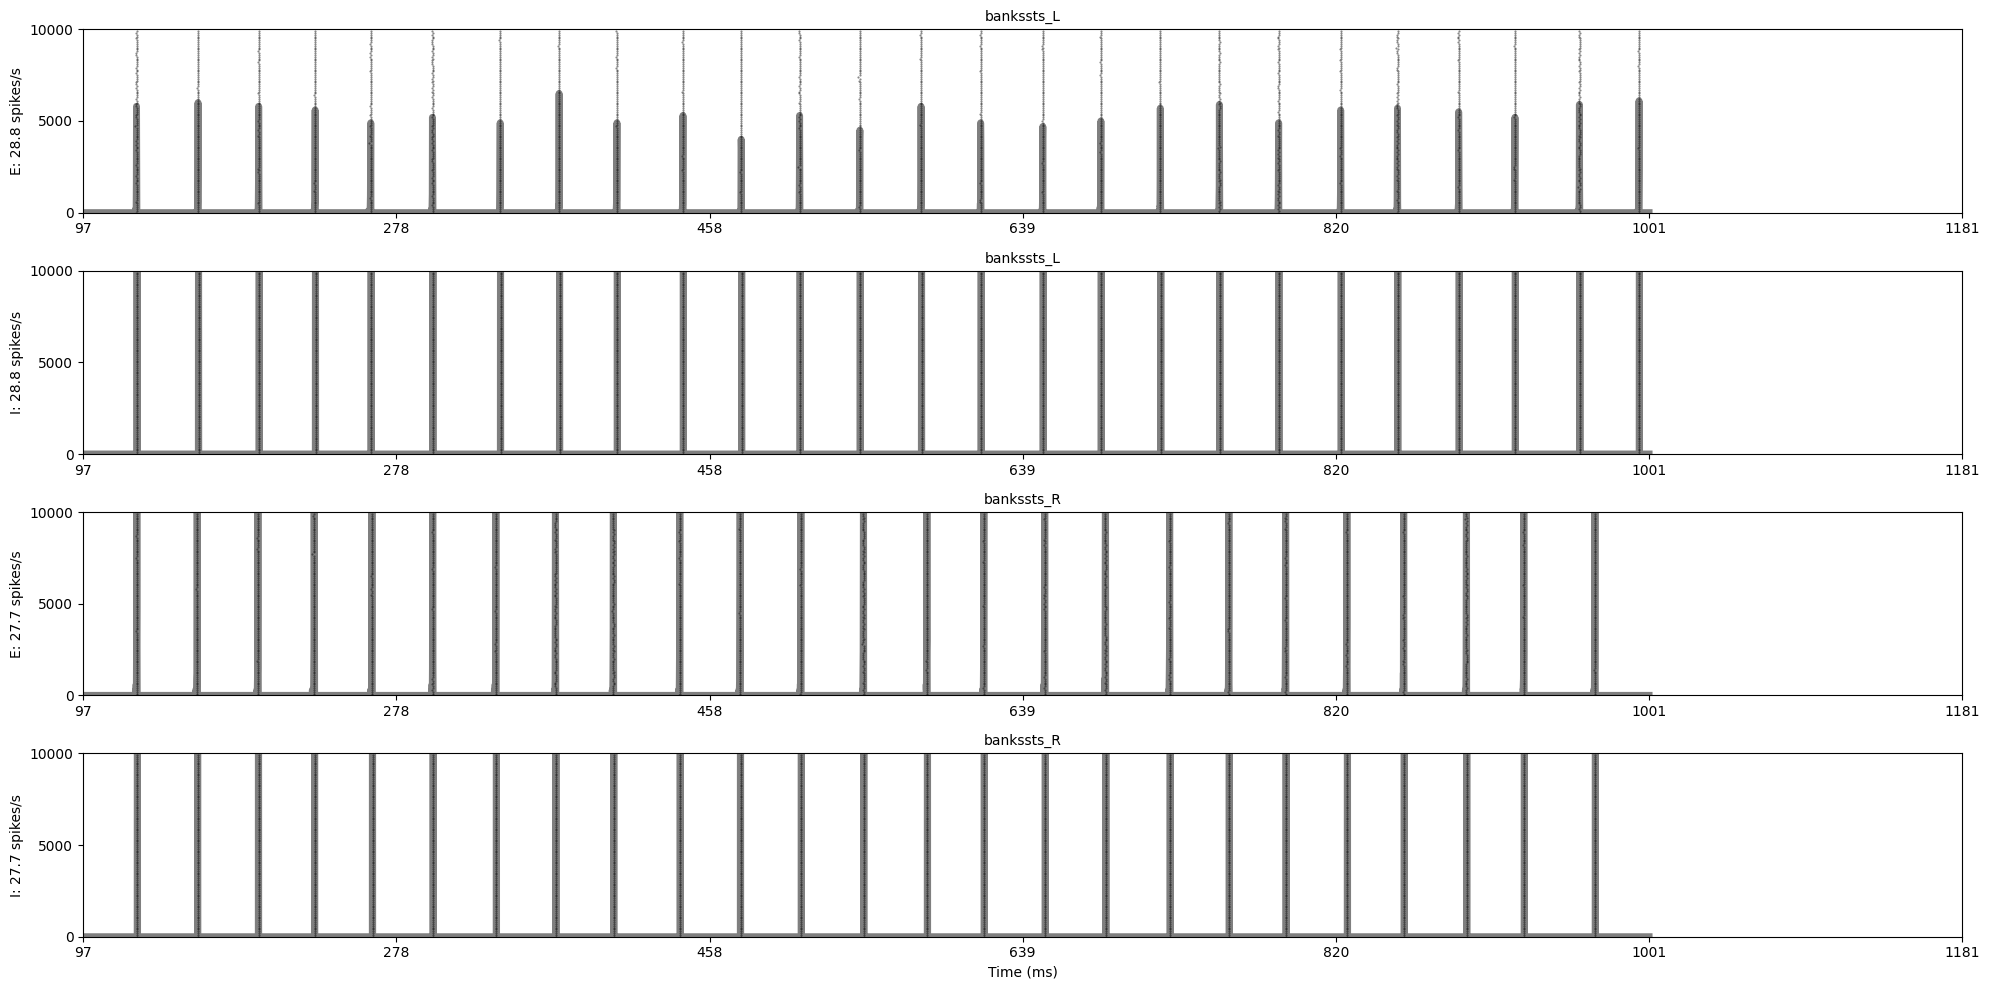

Mean spike rates:
E - bankssts_L: 28.7655
E - bankssts_R: 27.6592
I - bankssts_L: 28.7655
I - bankssts_R: 27.6592
<xarray.DataArray "Populations' Spikes' Correlation Coefficient" (
                                                                  Population_i: 2,
                                                                  Population_j: 2,
                                                                  Region_i: 2,
                                                                  Region_j: 2)>
array([[[[ 1.        ,  0.01370259],
         [ 0.01370259,  1.        ]],

        [[-0.00457904,  0.00242372],
         [ 0.04013956, -0.0045094 ]]],


       [[[-0.00457904,  0.04013956],
         [ 0.00242372, -0.0045094 ]],

        [[ 1.        , -0.00284382],
         [-0.00284382,  1.        ]]]])
Coordinates:
  * Population_j  (Population_j) object 'E' 'I'
  * Region_j      (Region_j) object 'bankssts_L' 'bankssts_R'
  * Population_i  (Population_i) object 'E' 'I'
  * Region_i    

<Figure size 640x480 with 0 Axes>

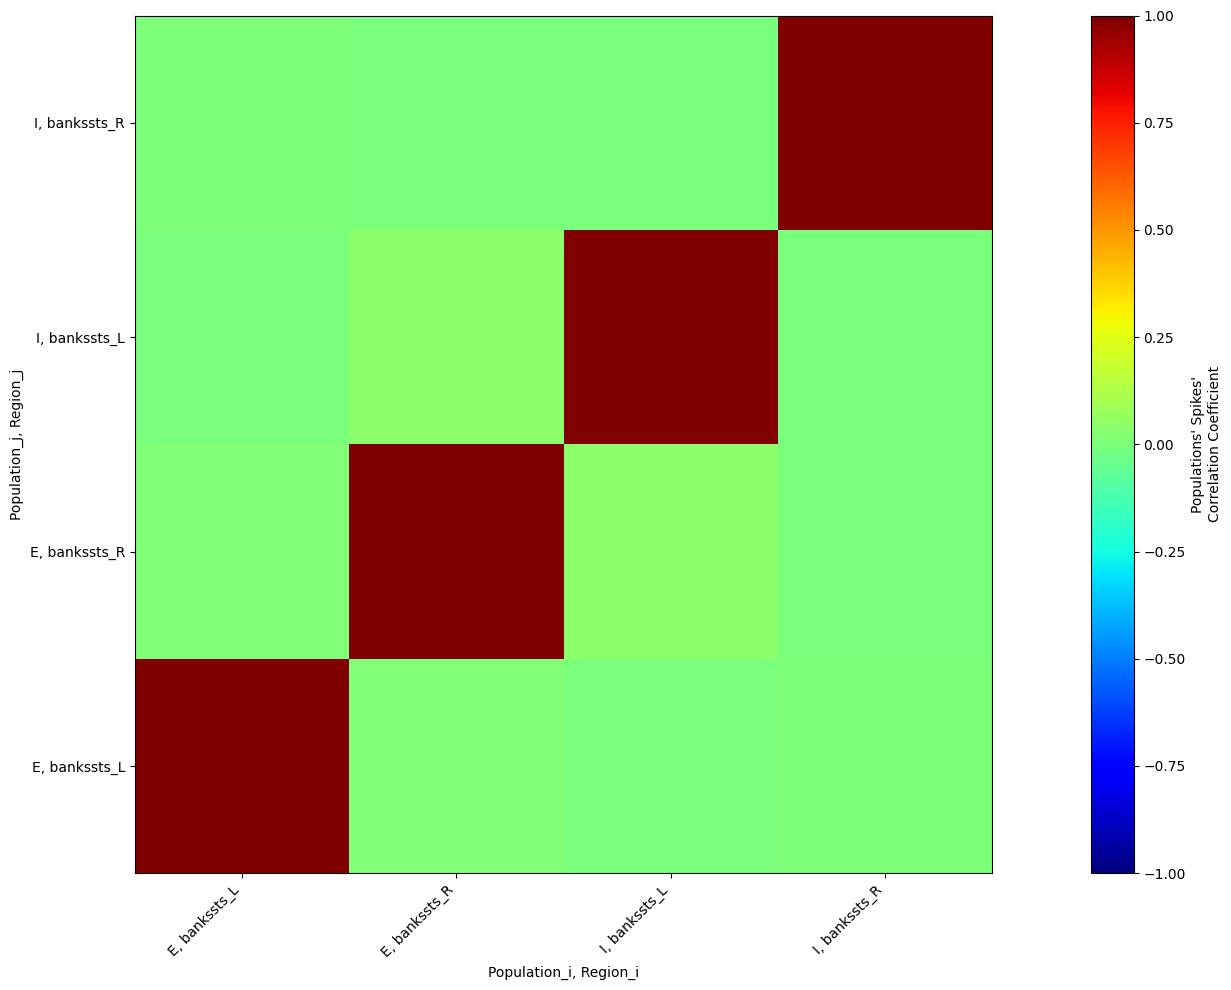

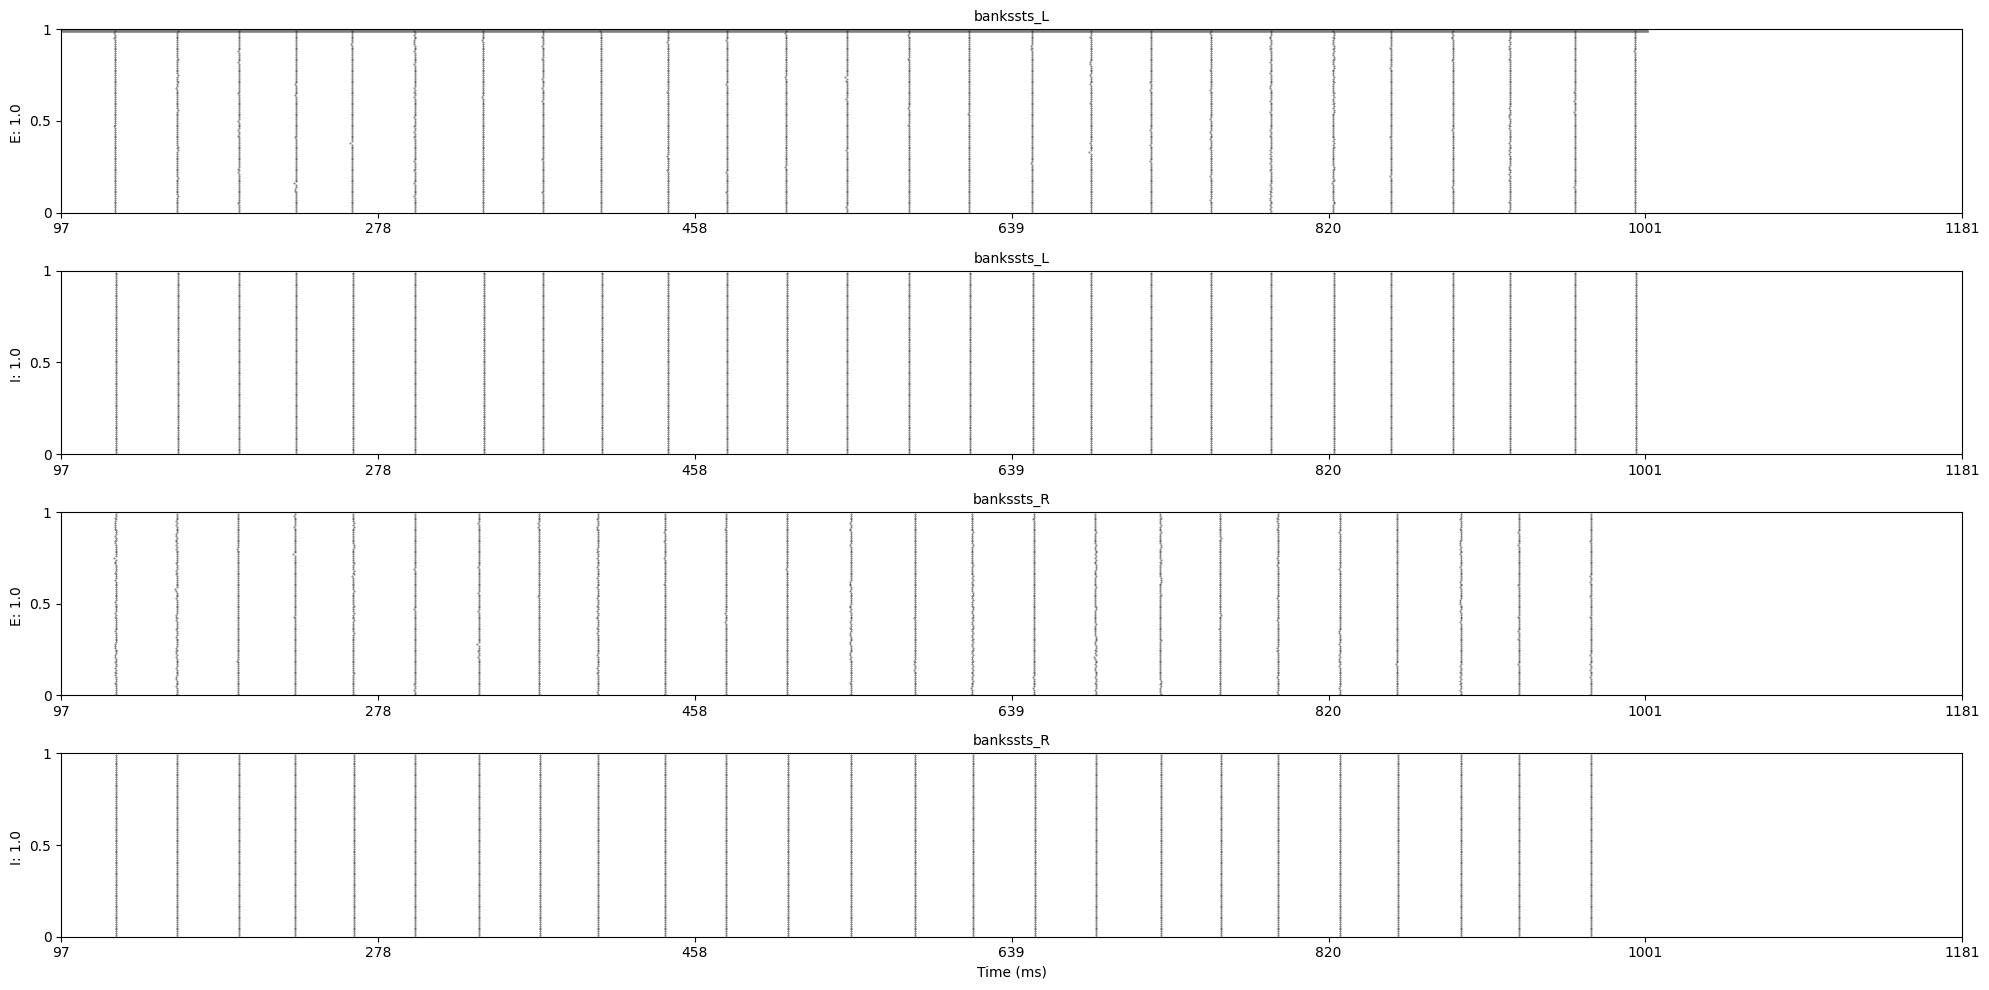

2023-06-29 15:02:37,582 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2023-06-29 15:02:37,584 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2023-06-29 15:02:37,603 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2023-06-29 15:02:37,606 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2023-06-29 15:02:37,621 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2023-06-29 15:02:37,623 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2023-06-29 15:02:38,118 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'

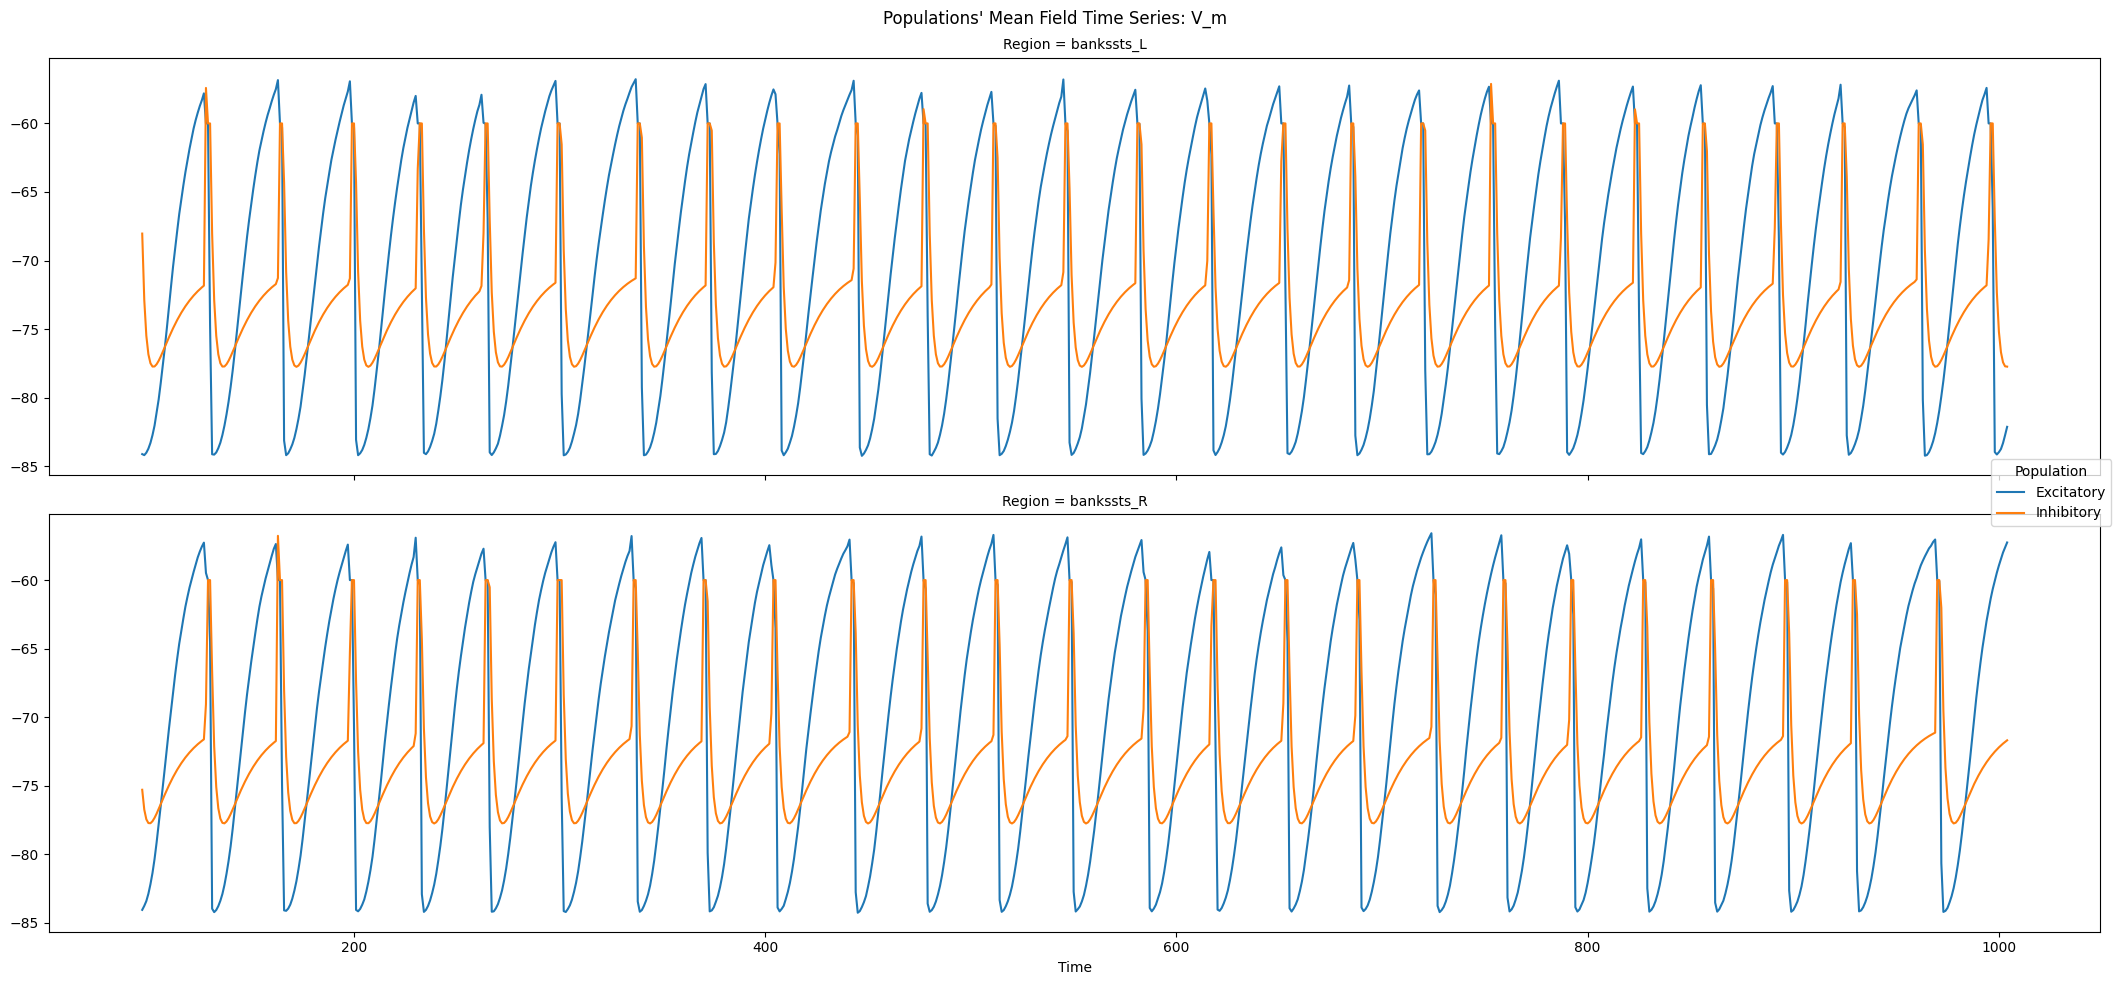


Cleaning up App NESTParallelApp...

Stopping App NESTParallelApp...

Plotting results with App TVBParallelApp...


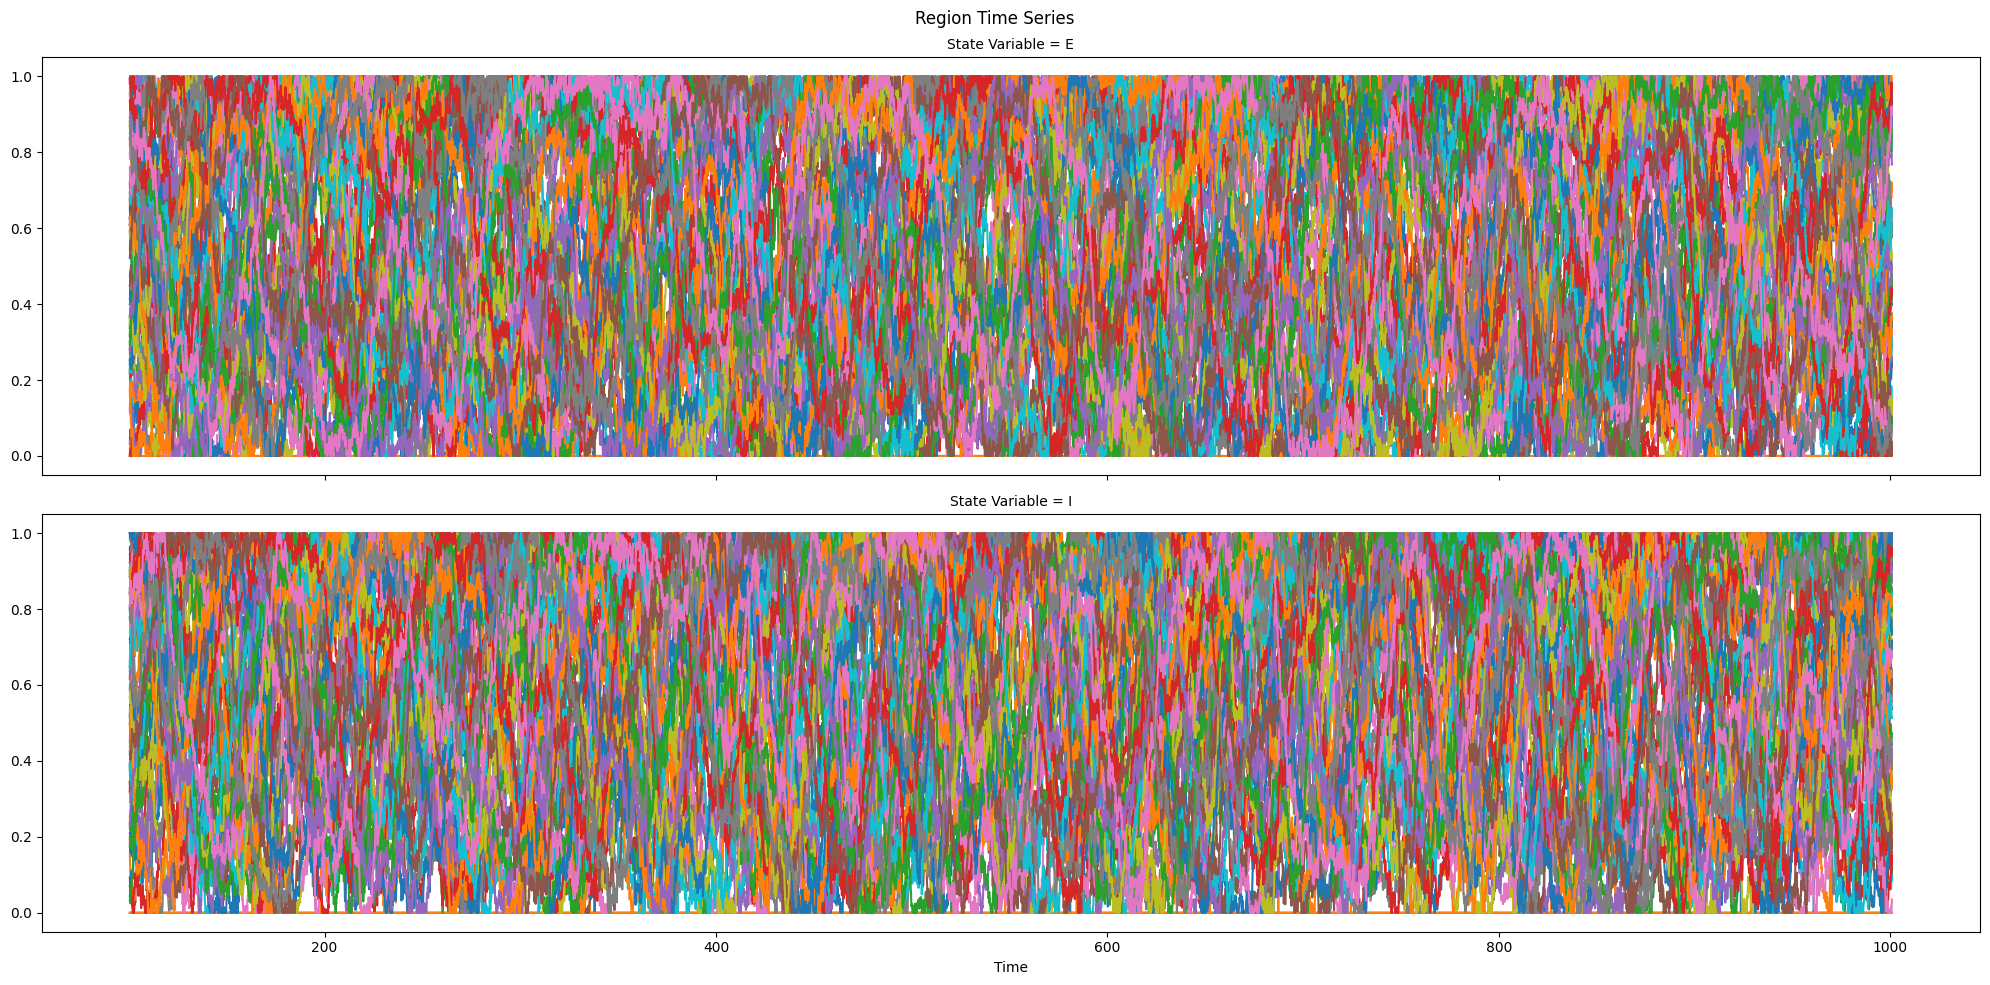

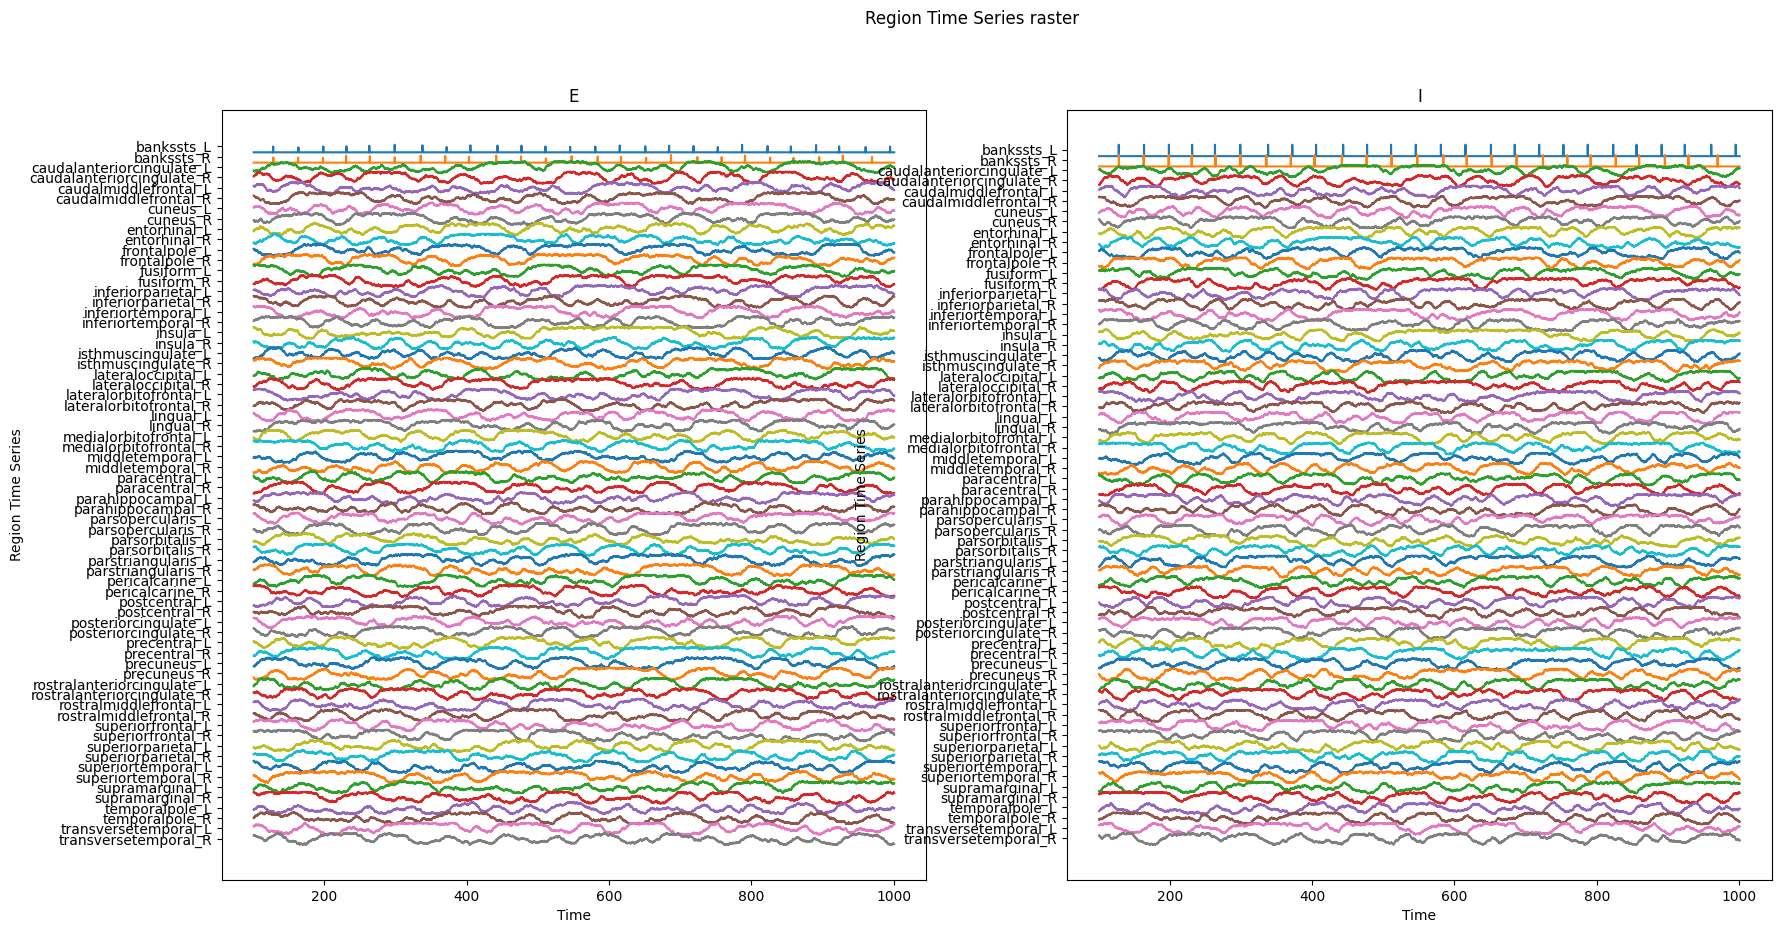

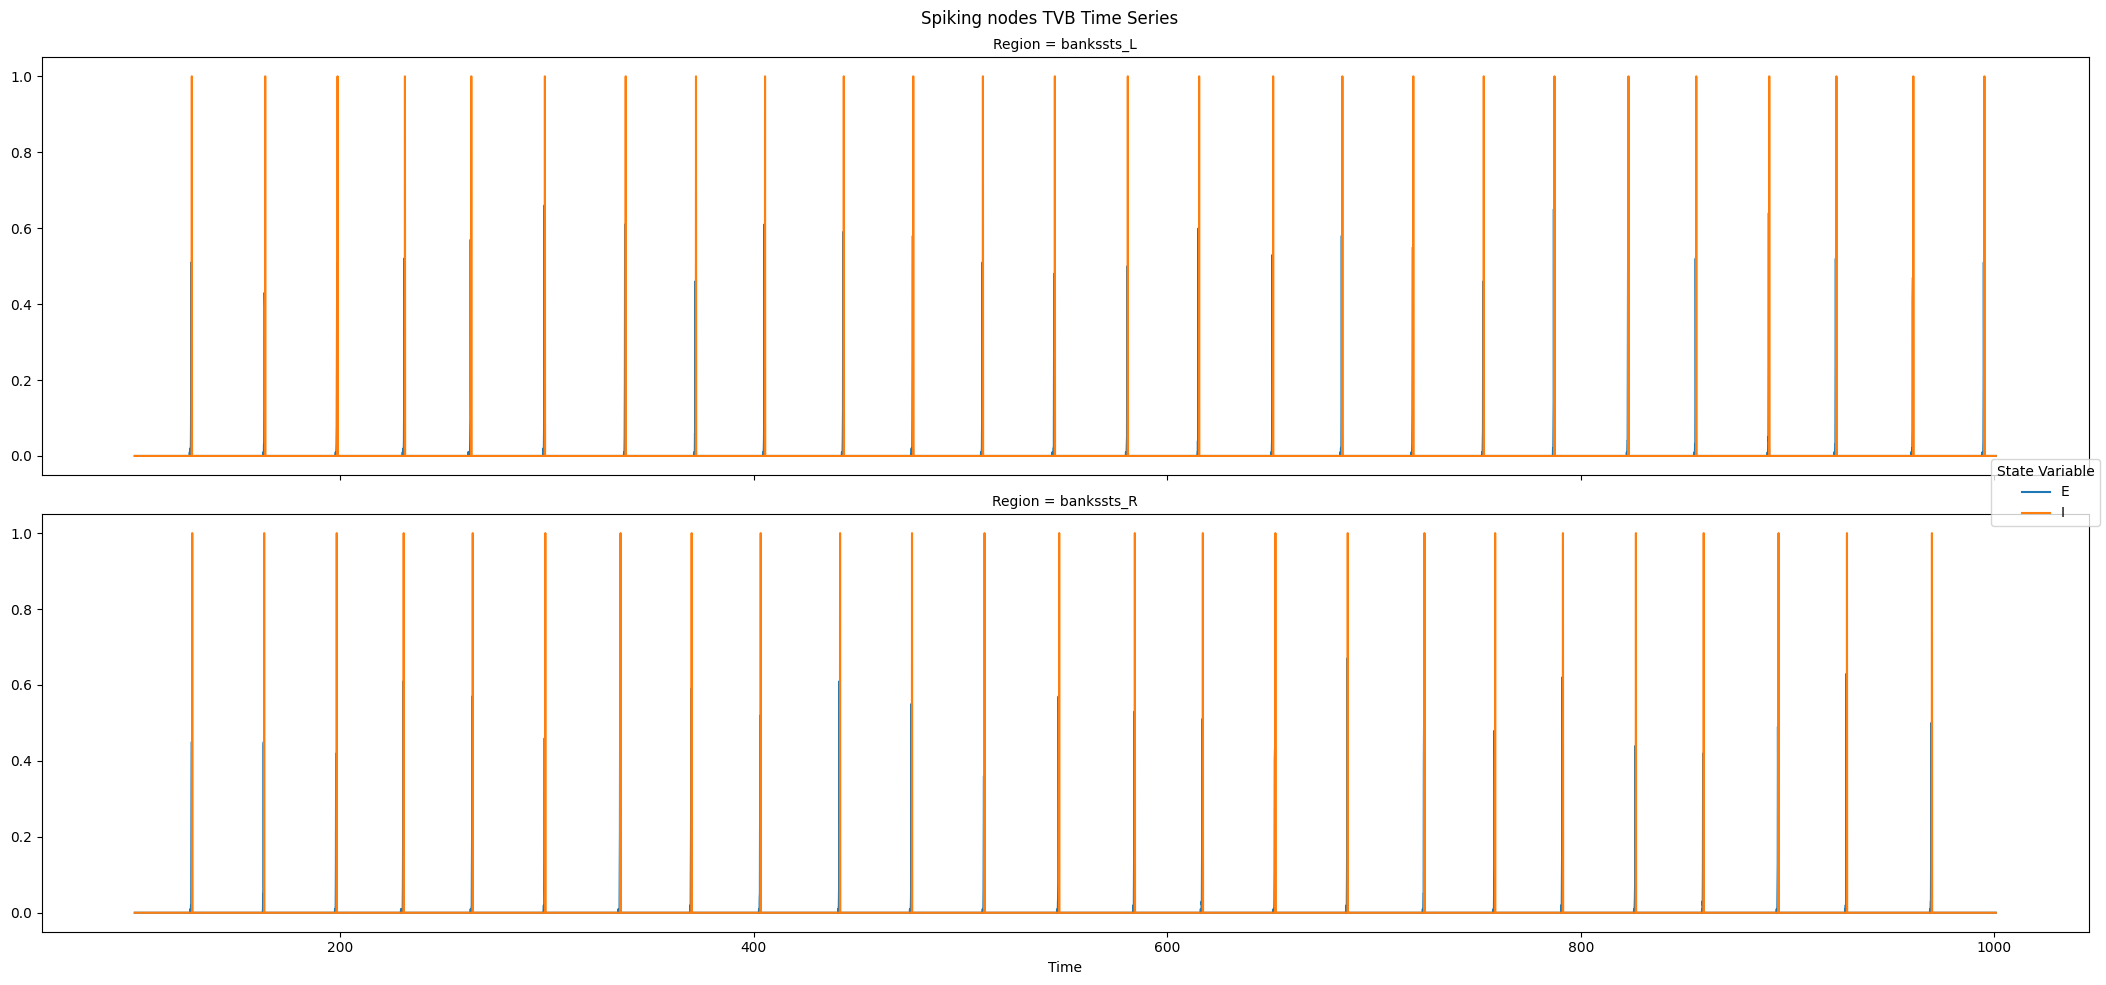


Cleaning up App TVBParallelApp...

Stopping App TVBParallelApp...


In [16]:
from nest_elephant_tvb.tvb.backend import final as tvb_final
from nest_elephant_tvb.nest.backend import final as nest_final
from nest_elephant_tvb.Interscale_hub.backend import final as trans_final
    
    
nest_to_tvb_app = trans_final(nest_to_tvb_app)
tvb_to_nest_app = trans_final(tvb_to_nest_app)
nest_app = nest_final(nest_app, plot=True, time=results[0][0], transient=transient,
                      plot_per_neuron=plot_per_neuron, plotter=plotter, writer=writer)
tvb_app = tvb_final(tvb_app, plot=True, transient=transient, plotter=plotter, writer=writer)

del tvb_app, nest_app, tvb_to_nest_app, nest_to_tvb_app


# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>